In [109]:
%run PBM.ipynb
%run lm_ode.ipynb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp
from sklearn.linear_model import LinearRegression

# Data import

In [3]:
df = pd.read_csv('particle_size.csv')
data = df.to_numpy()
size= data[:,0]
V = data[:,1:]/100
N = np.empty((61,6))
df2 = pd.read_csv('lognormal.csv')
data2 = df2.to_numpy()
mu = data2[0:4,-1]
sigma = data2[4:,-1]
T = np.array([0.,44.,88.,154.,330.,551.])

## Particle size
Mean particle size of miroflocs, primary particles, colloidal substances are decreasing as sonication time increases. Simple linear regression was adopted for mean particle size reduction.

In [212]:
t = T.reshape((-1,1))[1:]

In [216]:
mm = LinearRegression().fit(t, mu[1,1:])
pm = LinearRegression().fit(t, mu[2,1:])
cm = LinearRegression().fit(t, mu[3,1:])

In [217]:
def mu_micro(T):
    return mm.predict(T)
def mu_primary(T):
    return pm.predict(T)
def mu_colloidal(T):
    return cm.predict(T)

In [193]:
ynew = model.predict(x)

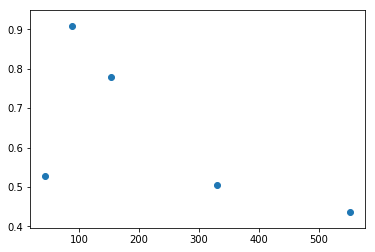

In [224]:
plt.scatter(T,sigma[3])

## Data interpolation
Since PBM has limitation on selection of particle size such as $l_{i+1}=2^{1/3}l_i$, size from the instrument should be interpolated to the size suitable to PBM. Cubic spline was adopted for the interpolation.

In [39]:
n = 41
L = np.empty(n)
L[0] = size[0]
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
Vcs = np.empty((n,6))
for i in range(6):
    Vcs[:,i] = CubicSpline(size,V[:,i])(L)

# Convert volume to number
Simple relation between volume and number
\begin{equation}
V_i=N_i\times l_i^3
\end{equation}
was assumed.

In [41]:
N = np.empty((n,6))
for i in range(6):
    N[:,i] = np.divide(Vcs[:,i],L**3)

In [42]:
N0 = N[:,0]
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

## Breakage function by log normal distribution

In [71]:
# microfloc
b1 = 0.7
# primary particle
b2 = 0.21
# colloidal substances
b3 = 1.0-b1-b2
def breakfunc(x,l):
    bf=b1*lognorm_b(x,l,mu[1],sigma[1])+b2*lognorm_b(x,l,mu[2],sigma[2])+b3*lognorm_b(x,l,mu[3],sigma[3])
    return bf

## Selection function
\begin{equation}
S(l)=S_0l^p
\end{equation}

In [60]:
S0 = 1e-7
p = 3
def selectionfunc(l):
    return S0*l**p

In [72]:
bmat = breakage_mat(selectionfunc,breakfunc,L,n)
Svec = selection_rate(selectionfunc,breakfunc,L,n,bmat)

calculating breakage matrix
calculating selection vector


In [91]:
def dydx(t,y):
    return breakage_moment(y,bmat,Svec,L)

In [94]:
sol = solve_ivp(dydx,[T[0],T[-1]],Y0,method='Radau',t_eval=T)
N = sol.y[0:-4,:]
M = sol.y[-4:,:]
V= np.empty(np.shape(N))
for i in range(6):
    V[:,i] = np.multiply(N[:,i],L**3)

(2, 0)

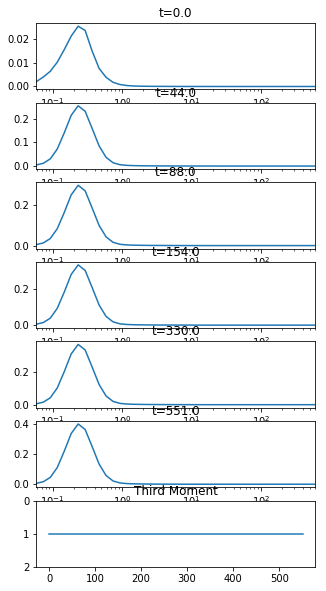

In [95]:
rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([2,0])

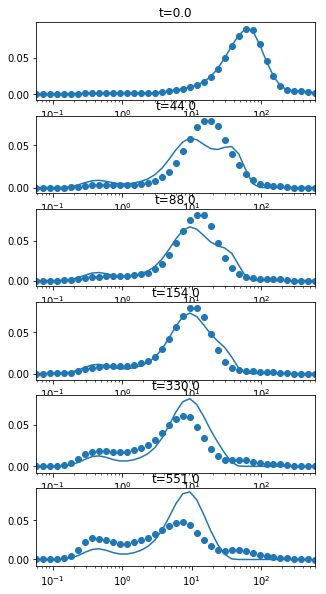

In [96]:
fig, axes = plt.subplots(rows,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,V[:,i])
    axes[i].scatter(L,Vcs[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

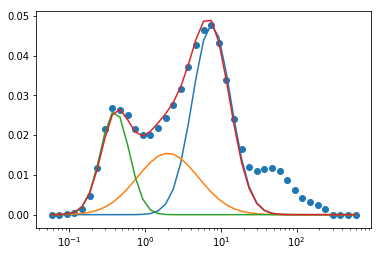

In [87]:
def lnpdf(x,mu,sigma):
    return np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/(x*sigma*np.sqrt(2*np.pi))
plt.plot(L,lnpdf(L,mu[1]+sigma[1]**2,sigma[1])/1.6)
plt.plot(L,lnpdf(L,mu[2]+sigma[2]**2,sigma[2])/9)
plt.plot(L,lnpdf(L,mu[3]+sigma[3]**2,sigma[3])/80)
plt.plot(L,lnpdf(L,mu[1]+sigma[1]**2,sigma[1])/1.9+lnpdf(L,mu[2]+sigma[2]**2,sigma[2])/6+lnpdf(L,mu[3]+sigma[3]**2,sigma[3])/100)
plt.scatter(L,Vcs[:,5])
plt.xscale('log')

In [107]:
p = 3
def PBM_AS(y,k):
    # parameters
    # k[0] = S0
    # k[1] = b1 : microfloc
    # k[2] = b2 : primary particle
    # 1-k[1]-k[2] = b3 : colloidal particle
    def breakfunc(x,l):
        bf=k[1]*lognorm_b(x,l,mu[1],sigma[1]) \
            +k[2]*lognorm_b(x,l,mu[2],sigma[2]) \
            +(1-k[1]-k[2])*lognorm_b(x,l,mu[3],sigma[3])
        return bf
    def selectionfunc(l):
        return k[0]*l**p
    bmat = breakage_mat(selectionfunc,breakfunc,L,n)
    Svec = selection_rate(selectionfunc,breakfunc,L,n,bmat)
    return breakage(y,bmat,Svec)

In [100]:
df = pd.read_csv('particle_size.csv')
data = df.to_numpy()
size= data[:,0]
V = data[:,1:]/100
N = np.empty((61,6))
df2 = pd.read_csv('lognormal.csv')
data2 = df2.to_numpy()
mu = data2[0:4,-1]
sigma = data2[4:,-1]
T = np.array([0.,44.,88.,154.,330.,551.])

In [103]:
n = 41
L = np.empty(n)
L[0] = size[0]
for i in range(n-1):
    L[i+1] = L[i]*2**(1/3)
Vcs = np.empty((n,6))
for i in range(6):
    Vcs[:,i] = CubicSpline(size,V[:,i])(L)
N = np.empty((n,6))
for i in range(6):
    N[:,i] = np.divide(Vcs[:,i],L**3)    
Q = np.diag(L**3)
N0 = N[:,0]
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

In [110]:
k0 = np.array([1e-7,0.7,0.21])
est = gnlm(PBM_AS,N,Q,k0,T,[1e-3,1e-8,1e-8,10])

ValueError: cannot reshape array of size 0 into shape (3,41)